In [20]:
import mne
import os
import os.path as osp

import pandas as pd
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann.spatialfilters import Xdawn
import numpy as np
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import XdawnCovariances
from pyriemann.estimation import Covariances

import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


from numpy.random import seed

import winsound
import time



In [18]:
mne.set_log_level(verbose="Warning") # set all the mne verbose to warning

In [21]:

seed(2002012)


In [22]:
init_path = "C:\\Users\dtrocell\Documents\ML\Big dataset\signal"
files_dir=os.listdir(init_path)[1:4]
participant_dir= [os.listdir(osp.join(init_path,files_dir[i])) for i in range(len(files_dir))]
print("you have succesfuly acces to the directory : ",init_path)

you have succesfuly acces to the directory :  C:\Users\dtrocell\Documents\ML\Big dataset\signal


In [23]:
def collect_data(files_dir, participant_dir):
    dic_data_train ={}
    dic_data_test ={}
    for i in range(len(files_dir)):
        for j in range(len(participant_dir[i])):
            #Train dataset
            dic_data_train[participant_dir[i][j]+"_1"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R1_acquisition.gdf"), verbose="CRITICAL")
            dic_data_train[participant_dir[i][j]+"_2"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R2_acquisition.gdf"), verbose="CRITICAL")

            #Test dataset
            dic_data_test[participant_dir[i][j]+"_3"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R3_onlineT.gdf"), verbose="CRITICAL")
            dic_data_test[participant_dir[i][j]+"_4"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R4_onlineT.gdf"), verbose="CRITICAL")
            try : # allow to manage the one where there is no _5 and _6 files
                dic_data_test[participant_dir[i][j]+"_5"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R5_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass

            try :
                dic_data_test[participant_dir[i][j]+"_6"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R6_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass
    return dic_data_train, dic_data_test


In [24]:
print("START extraction data")
dic_data_train,dic_data_test=  collect_data(files_dir, participant_dir)
print("extraction data DONE")


START extraction data
extraction data DONE


Stimulation code
left =769
right = 770

In [25]:
def preprocess(raw, steps = {}):
    """ preprocess the data"""
    assert isinstance(steps, dict), "les steps doivent être un dictionnaire d'étapes"
    raw.load_data()
    if "drop_channels" in steps.keys():
        #remove the wanted channels
        for channel in steps["drop_channels"] : #Pour chaque channel  a supprimer
            if channel in raw.ch_names: raw.drop_channels(channel) # Vérifie qu'il est present et le supprime

    if "filter" in steps.keys():
        assert isinstance(steps["filter"], list), "les paramètres de 'filter' doivent une liste suivant cette forme [l_freq,h_freq]"
        raw.filter(steps["filter"][0], steps["filter"][1])


    return raw

In [10]:
#steps_preprocess = {"filter" : [1,32]}
#_ =  preprocess(dic_data_train["A2_1"],steps_preprocess)

In [11]:
def epoching(dict, key_session =[], steps_preprocess = None , key_events={"769":0 ,"770":1}) :
    """From the dictionary of mne.rawGDF extract all the epochs selected with Key_session
     Return the epochs list as X and tje label as Y"""

    #---------------------------------------------
    tmin= steps_preprocess["tmin"]
    tmax = steps_preprocess["tmax"]
    length_epoch = steps_preprocess["lenght"]
    overlap = steps_preprocess["overlap"]
    #---------------------------------------------
    X= None
    Y= None

    for key in key_session :


        if steps_preprocess is not None :
            _ =  preprocess(dict[key],steps_preprocess)

        epoch= mne.Epochs(dict[key], mne.events_from_annotations(dict[key],key_events)[0], tmin= -1 , tmax= 5 , baseline=(None, 0),  verbose="CRITICAL")

        list_start = np.arange(tmin, (tmax +overlap)- length_epoch, overlap)
        list_stop = np.arange(tmin+length_epoch, (tmax+overlap), overlap)



        for start, stop in zip(list_start, list_stop):
            if X is None :
                X = epoch.get_data(tmin=start , tmax=stop)
                Y = epoch.events[:,2]

            else :
                X = np.append(X,epoch.get_data(tmin=start , tmax=stop), axis= 0)
                Y = np.append(Y,epoch.events[:,2], axis=0)

    return X,Y



In [12]:
#steps_preprocess = {"filter" : [1,32]}
#key_events =  {"769":0 ,"770":1}
#X,Y = epoching(dic_data_train, ["A3_1","A1_2"], steps_preprocess)

# within session classification

In [13]:
#subject = "A1"
#train_key = [subject+"_1", subject+"_2"]
#test_key = [subject+"_3", subject+"_4",subject+"_5", subject+"_6"]

#X_train, Y_train = epoching(dic_data_train,train_key,steps_preprocess)
#X_test, Y_test = epoching(dic_data_test,test_key,steps_preprocess)


In [14]:



pipelines = {}

pipelines['8 csp+lda'] = make_pipeline(CSP(n_components=8), LDA())
pipelines['6 csp+lda'] = make_pipeline(CSP(n_components=6), LDA())
# # pipelines['xdawn+svm'] = make_pipeline(Xdawn(nfilter=2), LDA())
# pipelines['tgsp+svm'] = make_pipeline(Covariances(estimator='lwf'),
#                                       TangentSpace(metric='riemann'),
#                                       SVC(kernel='linear'))
pipelines['MDM'] = make_pipeline(Covariances(estimator='lwf'),
                               MDM(metric='riemann', n_jobs=-1))
pipelines['XDAWN+tgsp+svm'] = make_pipeline(Covariances(estimator='lwf'),
                                       TangentSpace(metric='riemann'),
                                        LogisticRegression())
# pipelines['XDAWN+tgsp+svm'] = make_pipeline(XdawnCovariances(estimator='lwf'),
#                                       TangentSpace(metric='riemann'),
#                                       SVC(kernel='linear'))
# pipelines['XDAWN+MDM'] = make_pipeline(XdawnCovariances(estimator='lwf'),
#                                  MDM(metric='riemann', n_jobs=-1))

#pipelines['FBSCP+ lda'] =make_pipeline(fbcsp(), LDA())


In [16]:



def test_pipeline_within_session(pipelines, session, steps_preprocess = None) :
    """ Take in input the different pipelines to test and return the corresponding classification accuracy"""

    accuracy =pd.DataFrame(np.zeros((len(session),len(pipelines))), index= session ,columns= pipelines.keys())

    for subject in session:

        train_key = [subject+"_1", subject+"_2"]
        if subject == "A59" : #Manage the error during the data acquisition
            test_key = [subject+"_3", subject+"_4"]
        else : #Take all the session possible
            test_key = [subject+"_3", subject+"_4", subject+"_5", subject+"_6"]

        print(subject)
        X_train, Y_train = epoching(dic_data_train,train_key, steps_preprocess)
        X_test, Y_test = epoching(dic_data_test,test_key, steps_preprocess)

        for classifier in pipelines.keys() :
                pipelines[classifier].fit(X_train,Y_train)

                # if steps_preprocess["score"] ==  "TAcc_false":
                #
                #     #---------------------------------------------
                #     tmin= steps_preprocess["tmin"]
                #     tmax = steps_preprocess["tmax"]
                #     length_epoch = steps_preprocess["lenght"]
                #     overlap = steps_preprocess["overlap"]
                #     #---------------------------------------------
                #     dist = len(np.arange(tmin, (tmax +overlap)- length_epoch, overlap))
                #     X_predict =pipelines[classifier].predict(X_test)
                #     X_estim =  pipelines[classifier].transform(X_test)
                #     temporary_accuracy = np.zeros((1,dist+1))
                #
                #     for i in range(dist):
                #         temporary_accuracy[0, i] = accuracy_score(X_predict[i :: dist-1], Y_test [i :: dist-1])
                #         # mesure the accuracy of each trial
                #         print("x predict : ", X_predict[i :: dist])
                #         print("X_estim : " , X_estim[i :: dist])
                #
                #     print(temporary_accuracy)
                #
                #     # its binary 0 if in mean the trial was badly identified 1 instead
                #     temporary_accuracy = np.around(temporary_accuracy)
                #     print(temporary_accuracy)
                #     accuracy[classifier] [subject]= temporary_accuracy.mean()

                if steps_preprocess["score"] ==  "TAcc":

                    #---------------------------------------------
                    tmin= steps_preprocess["tmin"]
                    tmax = steps_preprocess["tmax"]
                    length_epoch = steps_preprocess["lenght"]
                    overlap = steps_preprocess["overlap"]
                    #---------------------------------------------
                    dist = len(np.arange(tmin, (tmax +overlap)- length_epoch, overlap))
                    #X_predict =pipelines[classifier].predict(X_test)
                    X_estim =  pipelines[classifier].transform(X_test)

                    X_estim_reshape =X_estim.reshape((-1,dist))
                    X_sum = X_estim_reshape.sum(axis=0)

                    trial_predict = np.where(X_sum < 0, 0, 1) # si la sommme des predictions de chaque époch est négative alors le trial est prédit gauche (0) sinon il est prédit droit (1)
                    temporary_accuracy = np.where(trial_predict== Y_test[0::dist-1], 1,0) #Compare les prédictions avec les observations


                    # for i in range(dist):
                    #
                    #     sum_estim = X_estim[i :: dist-1].sum()nnuoh
                    #
                    #     if sum_estim <0 : #class predict left
                    #         if Y_test[i] == 0: #actual class left
                    #             temporary_accuracy[0, i] = 1
                    #         elif  Y_test[i] == 1:
                    #             temporary_accuracy[0, i] = 0
                    #         else :
                    #             raise ValueError("Y_test ne devrait avoir que des 0 et des 1")
                    #
                    #
                    #     elif sum_estim >=0 : #class predict right
                    #         if Y_test[i] == 1: #actual class right
                    #             temporary_accuracy[0, i] = 1
                    #         elif Y_test[i] == 0 :
                    #             temporary_accuracy[0, i] = 0
                    #         else :
                    #             raise ValueError("Y_test ne devrait avoir que des 0 et des 1")

                    #print(temporary_accuracy)

                    accuracy[classifier] [subject]= temporary_accuracy.mean()

                elif steps_preprocess["score"] ==  "EAcc":
                    try:
                        accuracy[classifier] [subject]=  pipelines[classifier].score(X_test,Y_test)
                    except :
                        accuracy[classifier] [subject]= np.nan
                else :
                    raise AttributeError("le type de score choisi n'existe pas. Vérifie l'ortographe ! ")
    winsound.Beep(440, 500)
    winsound.Beep(330, 400)
    winsound.Beep(550, 500)
    return accuracy

#participant_dir[0].remove('A59')
session = participant_dir[0] #get the list of participant in the first exeperiment
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.5 , "tmax" : 4, "overlap" :1/16, "lenght": 1,
                    "score" : "EAcc"}
accuracy = test_pipeline_within_session(pipelines, session, steps_preprocess)

A1
Reading 0 ... 230367  =      0.000 ...   449.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (1.650 sec)

Used Annotations descriptions: ['769', '770']
Using data from preloaded Raw for 40 events and 3073 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 40 events and 3073 original time points ...
Using data from preloaded Raw for 40 events and 3073 original time points ...
Using data from preloaded Raw for 40 events and 3073 original time points ...

KeyboardInterrupt: 

Retour Fabien :
IIR filtre  ordre 4
FIR ordre 50

"tmin" : 0.5 , "tmax" : 2.6, "overlap" :2, "lenght": 2}

# Visualisation des résultats

In [1]:
accuracy.mean(axis=0)

NameError: name 'accuracy' is not defined

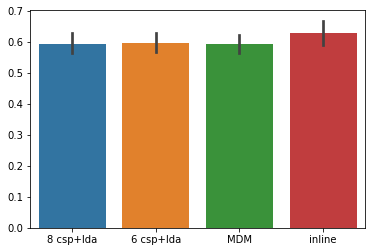

In [86]:
ax = sns.barplot(data= accuracy)

# Comparing to inline data

Text(0.5, 1.0, 'Comparaison des performances entre deux models')

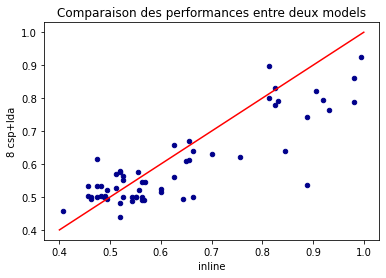

In [83]:
inline_accuracy = [84.375,55.625,98.125,51.25,51.25,65.625,47.5,56.225,66.25,82.5,51.875,60,65,49.375,75.625,49.375,45.625,82.5,98.125,83.125,56.875,88.75,51.875,93.125,81.25,65.625,45.625,48.125,52.5, 40.625, 52.5, 55.5, 62.5, 48.125, 90.625, 70, 47.5, 62.5, 81.25, 49.0625, 51.875, 51.875, 55, 56.25, 54.375, 54.375, 46.25, 56.625, 55, 52.5, 64.375, 88.75, 46.25, 47.5, 91.875, 99.375, 48.75, 66.25, 60, 56.25, 84.375, 90.625, 60, 50, 82.5, 58.75, 51.875, 55, 60.625, 55.625, 47.5, 44.375, 86.25, 68.125, 71.875, 80.625, 53.75, 55, 97.5, 49.375, 55, 49.375, 44.375, 76.25, 80.625, 62.5 ,73.125]

inline_order = ["A1"  ,"A2" ,"A3" ,"A4" ,"A5" ,"A6" ,"A7" ,"A8" ,"A9" ,"A10" ,"A11" ,"A12" ,"A13" ,"A14" ,"A15" ,"A16" ,"A17" ,"A18" ,"A19" ,"A20" ,"A21" ,"A22" ,"A23" ,"A24" ,"A25" ,"A26" ,"A27" ,"A28" ,"A29" ,"A30" ,"A31" ,"A32" ,"A33" ,"A34" ,"A35" ,"A36" ,"A37" ,"A38" ,"A39" ,"A40" ,"A41" ,"A42" ,"A43" ,"A44" ,"A45" ,"A46" ,"A47" ,"A48" ,"A49" ,"A50" ,"A51" ,"A52" ,"A53" ,"A54" ,"A55" ,"A56" ,"A57" ,"A58" ,"A59" ,"A60" ,"B61" ,"B62" ,"B63" ,"B64" ,"B65" ,"B66" ,"B67" ,"B68" ,"B69" ,"B70" ,"B71" ,"B72" ,"B73" ,"B74" ,"B75" ,"B76" ,"B77" ,"B78" ,"B79" ,"B80" ,"B81" ,"C82" ,"C83" ,"C84" ,"C85" ,"C86" ,"C87"]




inline_results = pd.DataFrame(inline_accuracy, inline_order, columns= ["inline"])
inline_results = inline_results/100

accuracy["inline"] = inline_results["inline"][accuracy.index]

ax1 = accuracy.plot.scatter(x='inline',y='8 csp+lda', c='DarkBlue')
ax1.plot([0.4,1],[0.4,1], c="red")
ax1.set_title("Comparaison des performances entre deux models")

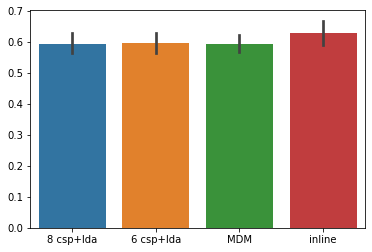

In [74]:
ax = sns.barplot(data= accuracy)

# Removing bad participants

Bad participants are defined by Pauline. It can be because of one specific channel is bad or others problem.

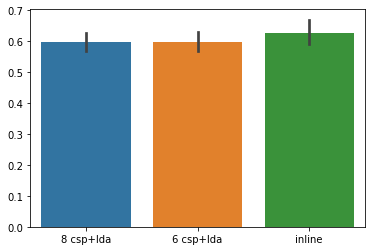

In [52]:
bad_subjects = ["A3","A4","A5","A9","A11","A17","A27","A28","A29","A30","A31","A32","A37","A38","A41","A43","A46","A47","A49","A53","A60"]#,"B64","B67","B68","B69","B70","B78","B79","B81","C82","C83","C86"]

cleaned_accuracy =accuracy.drop(bad_subjects)
ax = sns.barplot(data= accuracy)

In [53]:
cleaned_accuracy.mean()

8 csp+lda    0.627548
6 csp+lda    0.627115
inline       0.675010
dtype: float64

# Bug et issues identifier dans le code
## Steps epoching

List start stop permet de gerer l'epoching avec overlap. Pour cela on utiliser la fonction np.arrange qui permet à partir d'un temps de début et de fin une liste de temps a prendre en compte.
ATTENTION a que la derniere valeur de list_stop soit <= 5 elle est determiné par tmax+overlap
Tu peux vérifier le comportement avec la cellule ci dessous

In [74]:

tmin= 0.5
tmax = 5
length_epoch = 1
overlap = 1/16


list_start = np.arange(tmin, (tmax +overlap)- length_epoch, overlap)
list_stop = np.arange(tmin+length_epoch, (tmax+overlap), overlap)
print(list_start,list_stop, list_start-list_stop)

[0.5    0.5625 0.625  0.6875 0.75   0.8125 0.875  0.9375 1.     1.0625
 1.125  1.1875 1.25   1.3125 1.375  1.4375 1.5    1.5625 1.625  1.6875
 1.75   1.8125 1.875  1.9375 2.     2.0625 2.125  2.1875 2.25   2.3125
 2.375  2.4375 2.5    2.5625 2.625  2.6875 2.75   2.8125 2.875  2.9375
 3.     3.0625 3.125  3.1875 3.25   3.3125 3.375  3.4375 3.5    3.5625
 3.625  3.6875 3.75   3.8125 3.875  3.9375 4.    ] [1.5    1.5625 1.625  1.6875 1.75   1.8125 1.875  1.9375 2.     2.0625
 2.125  2.1875 2.25   2.3125 2.375  2.4375 2.5    2.5625 2.625  2.6875
 2.75   2.8125 2.875  2.9375 3.     3.0625 3.125  3.1875 3.25   3.3125
 3.375  3.4375 3.5    3.5625 3.625  3.6875 3.75   3.8125 3.875  3.9375
 4.     4.0625 4.125  4.1875 4.25   4.3125 4.375  4.4375 4.5    4.5625
 4.625  4.6875 4.75   4.8125 4.875  4.9375 5.    ] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -

# Visualisation données filtres CSP

In [79]:
subject = "A19"
train_key = [subject+"_1", subject+"_2"]

steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.25 , "tmax" : 5, "overlap" :1/16, "lenght": 1}

x_train, y_train = epoching(dic_data_train,train_key,steps_preprocess)

Used Annotations descriptions: ['769', '770']
Used Annotations descriptions: ['769', '770']


In [80]:
csp = CSP(n_components=8)
_ =csp.fit(x_train, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 27 dim * 2.1e+10  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 27 data channels with 0 projectors
Reducing data rank from 27 -> 27
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 27 dim * 2.1e+10  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 27 data channels with 0 projectors
Reducing data rank from 27 -> 27
Estimating covariance using EMPIRICAL
Done.


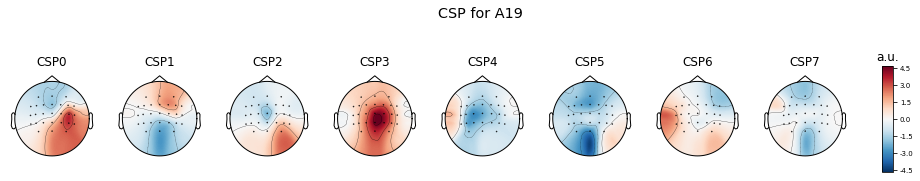

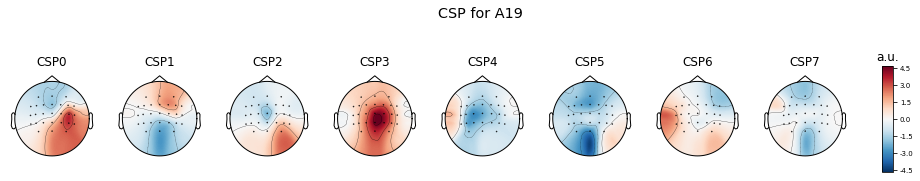

In [82]:
epoch = preprocess(dic_data_train["A10_1"], steps_preprocess)
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
epoch.set_montage(ten_twenty_montage)
csp.plot_patterns(epoch.info, title="CSP for %s " %subject)

In [131]:
subject = "A10"
train_key = [subject+"_1", subject+"_2"]

steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.25 , "tmax" : 5, "overlap" :1/16, "lenght": 1}

x_train, y_train = epoching(dic_data_train,train_key,steps_preprocess)

csp = CSP(n_components=6)
csp.fit(x_train, y_train)
epoch = preprocess(dic_data_train["A10_1"], steps_preprocess)
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
epoch.set_montage(ten_twenty_montage)
csp.plot_patterns(epoch.info)

In [6]:
print('"dc')


a =1
B= a +1

"dc


Traceback (most recent call last):
  File "_pydevd_bundle\pydevd_cython_win32_39_64.pyx", line 1035, in _pydevd_bundle.pydevd_cython_win32_39_64.PyDBFrame.trace_dispatch
  File "C:\Program Files\JetBrains\DataSpell 2021.3\plugins\python-ce\helpers-pro\jupyter_debug\pydev_jupyter_plugin.py", line 144, in cmd_step_over
    if _is_inside_jupyter_cell(frame, pydb):
  File "C:\Program Files\JetBrains\DataSpell 2021.3\plugins\python-ce\helpers-pro\jupyter_debug\pydev_jupyter_plugin.py", line 209, in _is_inside_jupyter_cell
    if is_cell_filename(filename):
  File "C:\Program Files\JetBrains\DataSpell 2021.3\plugins\python-ce\helpers-pro\jupyter_debug\pydev_jupyter_plugin.py", line 220, in is_cell_filename
    ipython_shell = get_ipython()
NameError: name 'get_ipython' is not defined


2378

In [11]:
[0:6:2]

SyntaxError: invalid syntax (Temp/ipykernel_28556/3089502966.py, line 1)

In [14]:
inline_order = ["A1"  ,"A2" ,"A3" ,"A4" ,"A5" ,"A6" ,"A7" ,"A8" ,"A9" ,"A10" ,"A11" ,"A12" ,"A13" ,"A14" ,"A15" ,"A16" ,"A17" ,"A18" ,"A19" ,"A20" ,"A21" ,"A22" ,"A23" ,"A24" ,"A25" ,"A26" ,"A27" ,"A28" ,"A29" ,"A30" ,"A31" ,"A32" ,"A33" ,"A34" ,"A35" ,"A36" ,"A37" ,"A38" ,"A39" ,"A40" ,"A41" ,"A42" ,"A43" ,"A44" ,"A45" ,"A46" ,"A47" ,"A48" ,"A49" ,"A50" ,"A51" ,"A52" ,"A53" ,"A54" ,"A55" ,"A56" ,"A57" ,"A58" ,"A59" ,"A60" ,"B61" ,"B62" ,"B63" ,"B64" ,"B65" ,"B66" ,"B67" ,"B68" ,"B69" ,"B70" ,"B71" ,"B72" ,"B73" ,"B74" ,"B75" ,"B76" ,"B77" ,"B78" ,"B79" ,"B80" ,"B81" ,"C82" ,"C83" ,"C84" ,"C85" ,"C86" ,"C87"]

inline_order[1::2]

['A2',
 'A4',
 'A6',
 'A8',
 'A10',
 'A12',
 'A14',
 'A16',
 'A18',
 'A20',
 'A22',
 'A24',
 'A26',
 'A28',
 'A30',
 'A32',
 'A34',
 'A36',
 'A38',
 'A40',
 'A42',
 'A44',
 'A46',
 'A48',
 'A50',
 'A52',
 'A54',
 'A56',
 'A58',
 'A60',
 'B62',
 'B64',
 'B66',
 'B68',
 'B70',
 'B72',
 'B74',
 'B76',
 'B78',
 'B80',
 'C82',
 'C84',
 'C86']

In [52]:

pipelines = {}

#pipelines['8 csp+lda'] = make_pipeline(CSP(n_components=8), LDA())
pipelines['6 csp+lda'] = make_pipeline(CSP(n_components=6), LDA())

TypeError: unsupported operand type(s) for +: 'dict_keys' and 'str'

In [ ]:
session = participant_dir[0] #get the list of participant in the first exeperiment
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.25 , "tmax" : 5, "overlap" :1/16, "lenght": 1,
                    "score" : "Tacc"}
accuracy_2  = test_pipeline_within_session(pipelines, session, steps_preprocess)

In [173]:
fusioned_accuracy = accuracy.join(accuracy_2, rsuffix = "_TAcc")

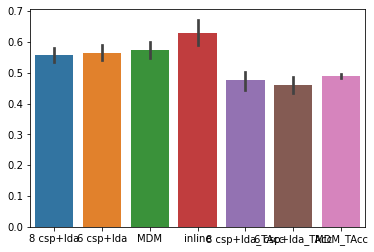

In [193]:
ax = sns.barplot(data= fusioned_accuracy)set_width